## Modelagem e Avaliação 

Neste tópico, iremos preparar nossos dados para modelagem, criando pipeline para garatir o correto pré-processamento dos nossos dados.Utilizaremos o modelo RandomForestClassifier, um modelo que me sinto bastante confortável por conhecer seu funcionamento e nuances. É um modelo não-linear, robusto a outliers e que não possui qualquer suposição sobre as distribuições, o que é algo bastante relevante, dado que a maioria dos dados na vida real apresentam não normalidade. Evitar a normalização é uma etapa a menos se você utiliza modelos baseados em árvore. Em suma, o RandomForest cria várias árvores de decisões, as quais são construídas com diferentes dados de um mesmo dataset (Bootstrap). Dessa maneira, o resultado final é obtido por votação majoritária.

## Dependências

In [42]:
# Bibliotecas
import os
import shap
import warnings
warnings.filterwarnings('ignore')
import cloudpickle
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, recall_score
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import ShuffleSplit,learning_curve,RepeatedStratifiedKFold
from sklearn import set_config
from optuna.samplers import TPESampler
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

## Dados e Constantes

In [43]:
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_RAW_NAME = 'diabetes_data.csv'
DATA_INTER_PATH = os.path.join('..','data','inter')
DATA_INTER_TEST_NAME = 'test_inter.csv'
DATA_INTER_TRAIN_NAME = 'train_inter.csv'
DATA_INTER_TRAIN_FT_SELECTION = 'train_inter_ft_selection.csv'
META_DATA_PATH = os.path.join(DATA_RAW_PATH,'dicionario_tipos.pkl')
MODEL_PATH = os.path.join('..','models')
MODEL_NAME = 'diagnostico_diabetes.pkl'
PREDICT_PATH = os.path.join('..','data','results')
PREDICT_NAME = 'previsao_diagnostico.csv'
target = 'target'

In [44]:
#Dados do dicionário
with open(META_DATA_PATH,'rb') as f:
    dicionario_tipo = cloudpickle.load(f)

df_train = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_FT_SELECTION), dtype=dicionario_tipo)


#Lendo dados de teste.
df_test = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TEST_NAME), dtype=dicionario_tipo)

## Modelagem 

In [45]:
df_train.head()

,idade,genero,polyuria,polydipsia,perda_de_peso_repentina,polyphagia,irritabilidade,paresia_parcial,alopecia,target
0,67,1,0,0,0,1,0,0,0,0
1,55,0,1,1,1,1,0,1,0,1
2,60,1,0,0,0,0,0,1,0,0
3,48,0,1,1,0,0,0,1,0,1
4,31,0,1,1,1,1,1,1,0,1


In [5]:
#Separando as variáveis categóricas e numéricas
variaveis_categoricas = df_train.select_dtypes(include=['object']).columns.tolist()
variaveis_numericas = df_train.select_dtypes(include=['int','float']).columns.tolist()

In [6]:
#Removendo target das variáveis categóricas. 
variaveis_categoricas.remove('target')

## Criando pipeline

Aqui iremos criar um pipeline para tratar dados categóricos e outro para tratar nossos dados numéricos. Dessa maneira cada coluna é tratada da forma mais adequada. O resultado é combinado no final e passado para o classificador, último componente do pipeline.

In [7]:
#Pipeline numérico será tratado imputando a mediana
pipeline_numerico = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])
#Pipeline categórico será tratado com imputação através da moda e ordinal encoder
pipeline_categorico = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                         ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore',drop='first'))])

In [8]:
#Column Transformer para unir os dois pipelines
preprocess_pipeline = ColumnTransformer([('pipeline_categorico', pipeline_categorico, variaveis_categoricas),
                                ('pipeline_numerico', pipeline_numerico, variaveis_numericas)])

## Modelagem e Avaliação

Aqui utilizaremos otimização bayesiana para busca dos melhores hiperparâmetros para o classificador. Poderíamos ter utilizado o GridSearchCV ou o RandomizedSearchCV, porém esses seriam mais lentos. Vale salientar que a otimização está sendo feita em cima da média de validação cruzada.

In [9]:
#Definindo folds para a validação cruzada estratificada para garantir uma melhor distribuição do target.
cv = RepeatedStratifiedKFold(random_state=2, n_splits=10, n_repeats=10)

In [10]:
cv 

RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=2)

In [11]:
# Definindo modelo com random_seed e class_weight='balanced' para dar peso às classes mais raras
rf = RandomForestClassifier(random_state=0, class_weight='balanced')
# defninindo pipeline final, onde o último componente é o classificador
modelo_pipe =  Pipeline(steps =[('preprocessor',preprocess_pipeline),
                                  ('model_rf',rf)])

In [12]:
#Obtendo X e Y 
X = df_train.drop(target,axis=1)
y = df_train[target]

In [13]:
cross_val_score(modelo_pipe,X,y, cv=cv, scoring = 'recall_weighted')

array([0.97619048, 0.97619048, 0.97619048, 0.9047619 , 0.97619048,
       1.        , 0.95121951, 1.        , 0.92682927, 1.        ,
       0.97619048, 0.95238095, 0.97619048, 1.        , 0.95238095,
       0.9047619 , 1.        , 0.97560976, 0.97560976, 0.97560976,
       1.        , 0.97619048, 0.92857143, 0.95238095, 0.97619048,
       1.        , 1.        , 0.92682927, 0.95121951, 0.92682927,
       1.        , 0.92857143, 1.        , 1.        , 0.95238095,
       0.97619048, 0.97560976, 0.95121951, 0.92682927, 0.97560976,
       0.97619048, 1.        , 0.97619048, 0.97619048, 1.        ,
       0.97619048, 0.95121951, 0.97560976, 0.92682927, 0.97560976,
       0.97619048, 0.97619048, 1.        , 0.97619048, 0.97619048,
       0.92857143, 0.97560976, 0.95121951, 0.97560976, 1.        ,
       0.97619048, 0.97619048, 0.97619048, 0.97619048, 0.92857143,
       0.97619048, 1.        , 1.        , 0.95121951, 0.95121951,
       0.97619048, 0.97619048, 1.        , 0.97619048, 0.97619

In [14]:
def fitRF(trial):
    "Train RandomForest Model"
# Grid de parametros otimizados
    params ={'model_rf__max_depth': trial.suggest_int('model_rf__max_depth',2,13),
          'model_rf__min_samples_leaf': trial.suggest_int('model_rf__min_samples_leaf',2,33),
          'model_rf__min_samples_split':trial.suggest_int('model_rf__min_samples_split',2,33),
          'model_rf__n_estimators': trial.suggest_int('model_rf__n_estimators',50,300)
      }
    earlyStop=20
    modelo_pipe.set_params(**params)


    results = np.mean(cross_val_score(modelo_pipe,X,y, cv=cv, scoring = 'neg_log_loss'))

    #score = results.mean()  
    #intervalo(results)
    print(f'LOG LOSS:{results}')
    return results

In [15]:
sampler = TPESampler(seed=123)  
study = optuna.create_study(sampler=sampler,direction='maximize')
study.optimize(fitRF, n_trials=25)
print(study.best_trial)

[I 2022-03-02 23:32:02,153] A new study created in memory with name: no-name-10a5fabb-de81-4f4c-b8e5-b511c97c1bc5
[I 2022-03-02 23:32:14,964] Trial 0 finished with value: -0.24120423886763032 and parameters: {'model_rf__max_depth': 10, 'model_rf__min_samples_leaf': 11, 'model_rf__min_samples_split': 9, 'model_rf__n_estimators': 188}. Best is trial 0 with value: -0.24120423886763032.


LOG LOSS:-0.24120423886763032


[I 2022-03-02 23:32:29,369] Trial 1 finished with value: -0.26091840968582364 and parameters: {'model_rf__max_depth': 10, 'model_rf__min_samples_leaf': 15, 'model_rf__min_samples_split': 33, 'model_rf__n_estimators': 221}. Best is trial 0 with value: -0.24120423886763032.


LOG LOSS:-0.26091840968582364


[I 2022-03-02 23:32:45,284] Trial 2 finished with value: -0.2563766857774786 and parameters: {'model_rf__max_depth': 7, 'model_rf__min_samples_leaf': 14, 'model_rf__min_samples_split': 12, 'model_rf__n_estimators': 232}. Best is trial 0 with value: -0.24120423886763032.


LOG LOSS:-0.2563766857774786


[I 2022-03-02 23:33:01,954] Trial 3 finished with value: -0.19337618371480833 and parameters: {'model_rf__max_depth': 7, 'model_rf__min_samples_leaf': 3, 'model_rf__min_samples_split': 14, 'model_rf__n_estimators': 235}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.19337618371480833


[I 2022-03-02 23:33:15,251] Trial 4 finished with value: -0.22608729317043874 and parameters: {'model_rf__max_depth': 4, 'model_rf__min_samples_leaf': 7, 'model_rf__min_samples_split': 19, 'model_rf__n_estimators': 183}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.22608729317043874


[I 2022-03-02 23:33:29,274] Trial 5 finished with value: -0.3132885912427124 and parameters: {'model_rf__max_depth': 9, 'model_rf__min_samples_leaf': 29, 'model_rf__min_samples_split': 25, 'model_rf__n_estimators': 203}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.3132885912427124


[I 2022-03-02 23:33:36,983] Trial 6 finished with value: -0.2459223088760037 and parameters: {'model_rf__max_depth': 10, 'model_rf__min_samples_leaf': 12, 'model_rf__min_samples_split': 13, 'model_rf__n_estimators': 107}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2459223088760037


[I 2022-03-02 23:33:47,812] Trial 7 finished with value: -0.2869742848541322 and parameters: {'model_rf__max_depth': 5, 'model_rf__min_samples_leaf': 22, 'model_rf__min_samples_split': 4, 'model_rf__n_estimators': 158}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2869742848541322


[I 2022-03-02 23:33:56,804] Trial 8 finished with value: -0.2673963500632893 and parameters: {'model_rf__max_depth': 7, 'model_rf__min_samples_leaf': 17, 'model_rf__min_samples_split': 15, 'model_rf__n_estimators': 128}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2673963500632893


[I 2022-03-02 23:34:09,068] Trial 9 finished with value: -0.31767494672533614 and parameters: {'model_rf__max_depth': 7, 'model_rf__min_samples_leaf': 30, 'model_rf__min_samples_split': 32, 'model_rf__n_estimators': 175}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.31767494672533614


[I 2022-03-02 23:34:28,806] Trial 10 finished with value: -0.2087480300461121 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 21, 'model_rf__n_estimators': 282}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2087480300461121


[I 2022-03-02 23:34:48,946] Trial 11 finished with value: -0.2087319513471552 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 21, 'model_rf__n_estimators': 292}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2087319513471552


[I 2022-03-02 23:35:08,758] Trial 12 finished with value: -0.2169065499837485 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 25, 'model_rf__n_estimators': 291}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2169065499837485


[I 2022-03-02 23:35:26,566] Trial 13 finished with value: -0.25170130645162053 and parameters: {'model_rf__max_depth': 3, 'model_rf__min_samples_leaf': 8, 'model_rf__min_samples_split': 23, 'model_rf__n_estimators': 257}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.25170130645162053


[I 2022-03-02 23:35:31,039] Trial 14 finished with value: -0.2091858116433318 and parameters: {'model_rf__max_depth': 5, 'model_rf__min_samples_leaf': 6, 'model_rf__min_samples_split': 8, 'model_rf__n_estimators': 54}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2091858116433318


[I 2022-03-02 23:35:48,370] Trial 15 finished with value: -0.2993503531747678 and parameters: {'model_rf__max_depth': 2, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 18, 'model_rf__n_estimators': 256}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2993503531747678


[I 2022-03-02 23:36:06,079] Trial 16 finished with value: -0.2878018705000829 and parameters: {'model_rf__max_depth': 9, 'model_rf__min_samples_leaf': 22, 'model_rf__min_samples_split': 28, 'model_rf__n_estimators': 259}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2878018705000829


[I 2022-03-02 23:36:28,359] Trial 17 finished with value: -0.21247267680993623 and parameters: {'model_rf__max_depth': 12, 'model_rf__min_samples_leaf': 6, 'model_rf__min_samples_split': 16, 'model_rf__n_estimators': 295}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.21247267680993623


[I 2022-03-02 23:36:46,080] Trial 18 finished with value: -0.2914657370699028 and parameters: {'model_rf__max_depth': 6, 'model_rf__min_samples_leaf': 23, 'model_rf__min_samples_split': 2, 'model_rf__n_estimators': 233}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2914657370699028


[I 2022-03-02 23:37:06,559] Trial 19 finished with value: -0.237091796090995 and parameters: {'model_rf__max_depth': 11, 'model_rf__min_samples_leaf': 10, 'model_rf__min_samples_split': 10, 'model_rf__n_estimators': 267}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.237091796090995


[I 2022-03-02 23:37:22,841] Trial 20 finished with value: -0.21654479024758821 and parameters: {'model_rf__max_depth': 8, 'model_rf__min_samples_leaf': 5, 'model_rf__min_samples_split': 20, 'model_rf__n_estimators': 215}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.21654479024758821


[I 2022-03-02 23:37:41,727] Trial 21 finished with value: -0.20877396121837896 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 21, 'model_rf__n_estimators': 281}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.20877396121837896


[I 2022-03-02 23:38:02,215] Trial 22 finished with value: -0.22783154723956758 and parameters: {'model_rf__max_depth': 12, 'model_rf__min_samples_leaf': 4, 'model_rf__min_samples_split': 28, 'model_rf__n_estimators': 300}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.22783154723956758


[I 2022-03-02 23:38:19,109] Trial 23 finished with value: -0.2376681416987394 and parameters: {'model_rf__max_depth': 12, 'model_rf__min_samples_leaf': 10, 'model_rf__min_samples_split': 16, 'model_rf__n_estimators': 244}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.2376681416987394


[I 2022-03-02 23:38:37,826] Trial 24 finished with value: -0.21720978163853683 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 4, 'model_rf__min_samples_split': 22, 'model_rf__n_estimators': 272}. Best is trial 3 with value: -0.19337618371480833.


LOG LOSS:-0.21720978163853683
FrozenTrial(number=3, values=[-0.19337618371480833], datetime_start=datetime.datetime(2022, 3, 2, 23, 32, 45, 284791), datetime_complete=datetime.datetime(2022, 3, 2, 23, 33, 1, 953854), params={'model_rf__max_depth': 7, 'model_rf__min_samples_leaf': 3, 'model_rf__min_samples_split': 14, 'model_rf__n_estimators': 235}, distributions={'model_rf__max_depth': IntUniformDistribution(high=13, low=2, step=1), 'model_rf__min_samples_leaf': IntUniformDistribution(high=33, low=2, step=1), 'model_rf__min_samples_split': IntUniformDistribution(high=33, low=2, step=1), 'model_rf__n_estimators': IntUniformDistribution(high=300, low=50, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE, value=None)


In [16]:
print(f'O modelo obteve um score de validação cruzada para o log loss de: {study.best_value}')

O modelo obteve um score de validação cruzada para o log loss de: -0.19337618371480833


In [17]:
#Definindo os melhores hiperparâmetros, baseados na busca feita com a otimização bayesiana
modelo_pipe.set_params(**study.best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline_categorico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['genero', 'polyuria',
                                                   'polydipsia',
                                                   'perda_de_peso_repentina',
                                                   'polyphagia',
                                                   'irritabilidade',
                                                   'paresia_parcial

In [18]:
# plotando o pipeline
set_config(display='diagram')
# Treinando o modelo
modelo_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline_categorico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['genero', 'polyuria',
                                                   'polydipsia',
                                                   'perda_de_peso_repentina',
                                                   'polyphagia',
                                                   'irritabilidade',
                                                   'paresia_parcial',
                                                   'alopecia']),
                                                 ('pipeline_numerico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['idade'])])),
                ('model_rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=7,
                                        min_samples_leaf=3,
                                        min_samples_split=14, n_estimators=235,
                                        random_state=0))])

## Curva de Aprendizado

Aqui utilizaremos a curva de aprendizado para diagnosticar possíveis problemas de viés ou variância.


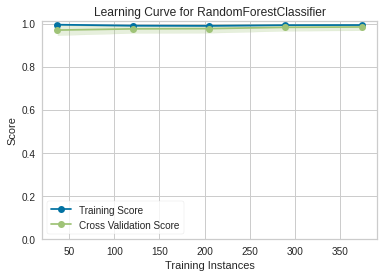

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [19]:
visualizer = LearningCurve(modelo_pipe, cv=cv, scoring='roc_auc', n_jobs=4, random_state = 123)
visualizer.fit(X, y)    
plt.ylim((0,1.01))
visualizer.show() 

Pela curva apresentada, vemos que existe a tendência do modelo atingir uma performance muito parecida no treinamento e no teste à medida que aumentamos o número de registros de treinamento. Talvez com uma base maior tenhamos um aumento de performance.

## Dados de teste

Agora que já treinamos o modelo e definimos os hiperparâmetros que maximizam nossa métrica, iremos comparar a perfomance do treino com a de teste.

In [20]:
#Renomeando colunas
df_test.rename(columns={'Age': 'idade','Gender':'genero','Polyuria':'polyuria','Polydipsia':'polydipsia','sudden weight loss':'perda_de_peso_repentina',
                        'weakness':'fraqueza','Polyphagia':'polyphagia','Genital thrush':'candidiase_genital',
                        'visual blurring':'desfoque_visual','Itching':'coceira','Irritability':'irritabilidade',
                        'delayed healing':'cicatrizacao_retardada','partial paresis':'paresia_parcial',
                        'muscle stiffness':'rigidez_muscular','Alopecia':'alopecia','Obesity':'obesidade','class':'target'},inplace=True)


In [21]:
variaveis_categoricas = set(df_test.select_dtypes(include=['object']).columns.tolist())
for var_cat in variaveis_categoricas:
    df_test[var_cat]=df_test[var_cat].str.lower()

In [22]:
#Selecionando colunas que foram selecionadas na parte de treino. 
df_test = df_test[['idade','genero','polyuria','polydipsia','perda_de_peso_repentina','polyphagia','irritabilidade','paresia_parcial','alopecia','target']]

In [37]:
df_test

,idade,genero,polyuria,polydipsia,perda_de_peso_repentina,polyphagia,irritabilidade,paresia_parcial,alopecia,target
0,35,female,yes,yes,no,no,no,no,no,positive
1,61,male,yes,no,no,yes,yes,yes,no,positive
2,28,male,no,no,yes,no,no,no,no,negative
3,35,female,no,yes,yes,no,no,yes,no,positive
4,53,male,no,no,no,yes,no,yes,yes,negative
5,44,male,yes,no,yes,no,no,no,yes,negative
6,45,male,no,no,no,yes,no,no,no,negative
7,36,female,no,no,no,no,yes,no,no,negative
8,35,female,yes,yes,yes,yes,no,yes,no,positive
9,58,male,no,no,no,no,no,yes,yes,positive


In [38]:
y_pred_test

array(['1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1',
       '1', '1', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0',
       '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '0',
       '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1',
       '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0',
       '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0',
       '1', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0',
       '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0'],
      dtype=object)

In [23]:
y_pred_test = modelo_pipe.predict(df_test.drop(target,axis=1))

In [24]:
score_teste = recall_score(df_test['target'], y_pred_test,average='weighted')
print(f'O modelo obteve um score de teste para o log loss de: {score_teste}')

O modelo obteve um score de teste para o log loss de: 0.0


Temos que avaliar nossa métrica versus a métrica da solução que já está disponível na empresa. Na ausência de um modelo existente, podemos utilizar "naive classifiers" construídos com regras simples, para medir qual ganho de performance temos ao implementarmos o modelo de machine-learning.

In [25]:
columns_predict = ['Diagnóstico_Diabetes']
df_previsoes= pd.DataFrame(y_pred_test, columns=columns_predict)

In [26]:
df_previsoes.head()

,Diagnóstico_Diabetes
0,1
1,0
2,0
3,1
4,0


In [27]:
df_previsoes.to_csv(os.path.join(PREDICT_PATH, PREDICT_NAME), index=False)

In [28]:
#Salvando modelo
with open(os.path.join(MODEL_PATH, MODEL_NAME), 'wb') as model:
    cloudpickle.dump(modelo_pipe, model)

## SHAP

Para interpretar o modelo existem diversas técnicas. O Random Forest, modelo utilizado, nos informa o Feature Importance, porém essa é uma técnica que pode ter algum viés, principalmente quando há presença de variáveis categóricas. Outra técnica rica é o Permutation Importance, que avalia a importância das features medindo a queda de performance quando esta é retirada. Nesse trabalho irei trazer o método de shap values, que é agnóstico a modelo e é baseado na teoria dos jogos.

A análise se interpretabilidade se fez necessário para responder a questão de forma mais segura: 

- Quais os 3 principais fatores que levam a um diagnóstico positivo de diabetes?

In [29]:
todas_as_variaveis = set(df_train.columns.tolist())
todas_as_variaveis.remove(target)

In [30]:
X_A1_test = df_test.drop(target, axis=1)
X_A1 = df_train.drop(target,axis=1)

In [31]:
# Ordenando variáveis e refitando o modelo (o SHAP dá problemas, bagunçando as colunas e o plot dá errado se não fizer)
X_A1_ = X_A1.loc[:,todas_as_variaveis]
X_A1_test_ = X_A1_test.loc[:,todas_as_variaveis]

In [32]:
# Lendo o modelo salvo 
with open(os.path.join(MODEL_PATH,MODEL_NAME),'rb') as m:
    modelo_salvo = cloudpickle.load(m)

In [33]:
X_A1_test_shap = pd.DataFrame(modelo_salvo['preprocessor'].transform(X_A1_test_), columns = todas_as_variaveis)

In [34]:
explainer_rf = shap.TreeExplainer(modelo_salvo['model_rf'])
shap_values = explainer_rf.shap_values(X_A1_test_shap, check_additivity=False)

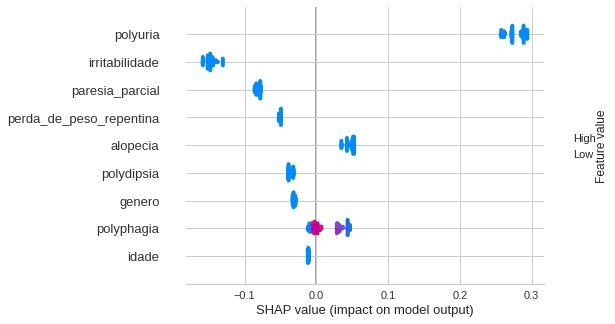

In [35]:
shap.summary_plot(shap_values[1], X_A1_test_shap)

## Quais os 3 principais fatores que levam a um diagnóstico positivo de diabetes?


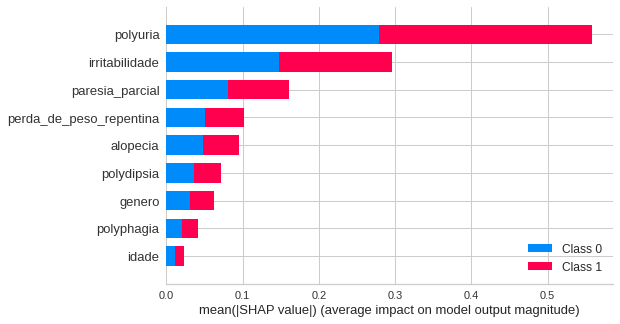

In [36]:
shap.summary_plot(shap_values,features=X_A1_test_shap, feature_names=X_A1_test_shap.columns,)

Com base, no feature importance e summary_plot as variáveis que apresentaram uma melhor relação para prever o diabetes, são: Perda de peso repentina, polydpsia, paresia parcial.